# TLDR

We investigate how pool size and LoD affect the test sensitivity for pools with {1,2,3} positives and individual tests, where viral loads are sampled from the same distribution as the one used for the network simulation.

Motivation for this analysis: we currently use LoD=174, and have seen no significant difference in NP and CP's performance across different pool sizes. We wonder whether it is because NP still has good enough sensitivity, and if so, whether we need to update our LoD to give CP more advantage.

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from seirsplus.calibration import _get_vl_with_plateau, gen_vl_distribution_with_plateau
from seirsplus.pooled_test import OneStageGroupTesting, run_one_PCR_test

In [42]:
# convert critical Ct values in Brault Table 1 to log10 VL
# TODO: the tail plateau seems pretty high, I think it should be somewhat smaller

def Ct_to_VL(Ct):
    return (14 + np.log10(1.105))-0.681/(np.log(10))*Ct

print(Ct_to_VL(22.6), Ct_to_VL(33.6), Ct_to_VL(20.1), Ct_to_VL(29.4), Ct_to_VL(34.8))

7.359309624840942 4.106009660903684 8.098695980281228 5.348178738043364 3.751104210292347


## Test the function for generating a single trajectory of expected viral load values over time

In [57]:
critical_time_points = [5, 7, 11, 16]
peak_plateau_height = 7.359
tail_plateau_height = 4.106

vls = []
sample_times = np.linspace(0, 20, 41)

for sample_time in sample_times:
    vls.append(_get_vl_with_plateau(
        critical_time_points,
        peak_plateau_height,
        tail_plateau_height,
        sample_time
    ))


Text(0.5, 1.0, 'Example expected viral load over time with plateau')

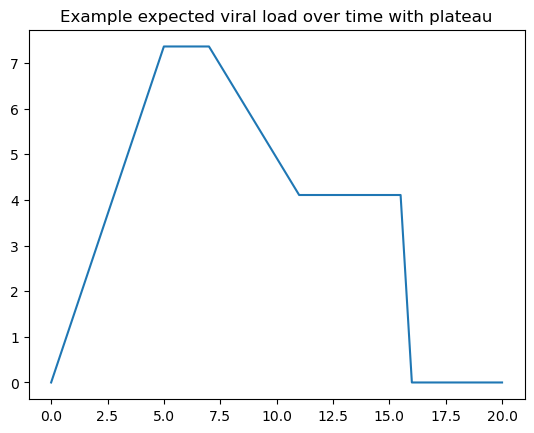

In [58]:

plt.plot(sample_times, vls)
plt.title("Example expected viral load over time with plateau")

## Test the function for sampling viral loads of a population

with noise added, i.e., VL_i(t) | params = E[VL(t) | params] + N(0, noise)

In [4]:
def get_gmm_samples(
    n_samples = 10000,
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
):
    gmm_samples = np.random.normal(
        loc = np.random.choice(means, size=n_samples, p=weights),
        scale = np.random.choice(sigmas, size=n_samples, p=weights)
    )
    return gmm_samples

(array([  1.,   0.,   1.,   1.,   0.,   2.,   1.,   7.,   5.,  17.,  21.,
         28.,  51.,  65., 111., 150., 216., 237., 323., 321., 402., 488.,
        490., 628., 668., 630., 539., 395., 360., 318., 272., 255., 269.,
        336., 341., 362., 378., 349., 275., 209., 154., 119.,  82.,  63.,
         24.,  15.,  11.,   5.,   2.,   3.]),
 array([-0.5217942 , -0.28333538, -0.04487655,  0.19358227,  0.4320411 ,
         0.67049993,  0.90895875,  1.14741758,  1.3858764 ,  1.62433523,
         1.86279406,  2.10125288,  2.33971171,  2.57817053,  2.81662936,
         3.05508819,  3.29354701,  3.53200584,  3.77046466,  4.00892349,
         4.24738232,  4.48584114,  4.72429997,  4.96275879,  5.20121762,
         5.43967645,  5.67813527,  5.9165941 ,  6.15505292,  6.39351175,
         6.63197058,  6.8704294 ,  7.10888823,  7.34734705,  7.58580588,
         7.82426471,  8.06272353,  8.30118236,  8.53964118,  8.77810001,
         9.01655884,  9.25501766,  9.49347649,  9.73193531,  9.97039414,
 

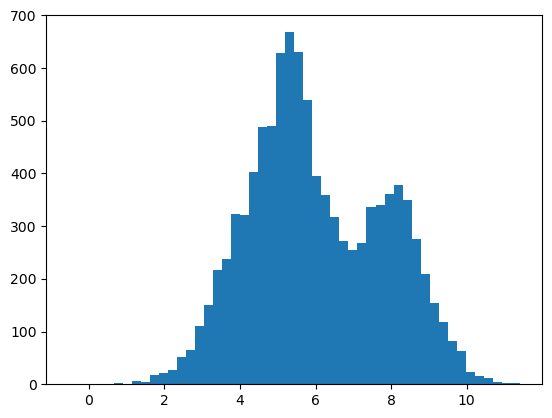

In [7]:
gmm_samples = get_gmm_samples()
plt.hist(gmm_samples, bins=50)

In [4]:
from scipy import stats

def get_gmm_pdf(
    x,
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
):
    res = []
    for x_ in x:
        res.append(np.sum([
            weights[i] * stats.norm.pdf(x_, loc=means[i], scale=sigmas[i])
            for i in range(len(weights))
        ]))
    return res
    

In [5]:
get_gmm_pdf(np.array([8, 10]))

[0.12662793481509543, 0.024495731561877676]

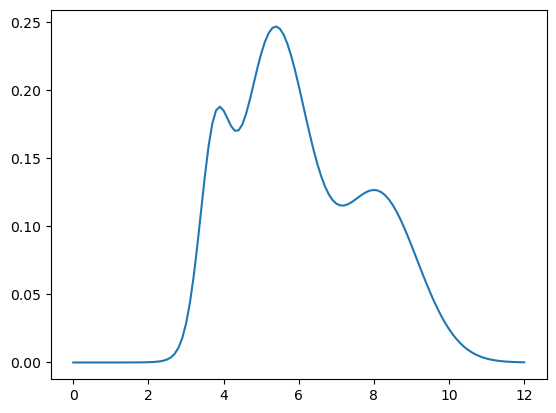

In [6]:
x = np.linspace(0, 12, 121)
gmm_pdf = get_gmm_pdf(x)
plt.plot(x, gmm_pdf)

# Tune a population with symptomatic and asymptomatic to match GMM

'\n    weights = [0.33, 0.54, 0.13],\n    means = [8.09, 5.35, 3.75],\n    sigmas = [1.06, 0.89, 0.39]\n'

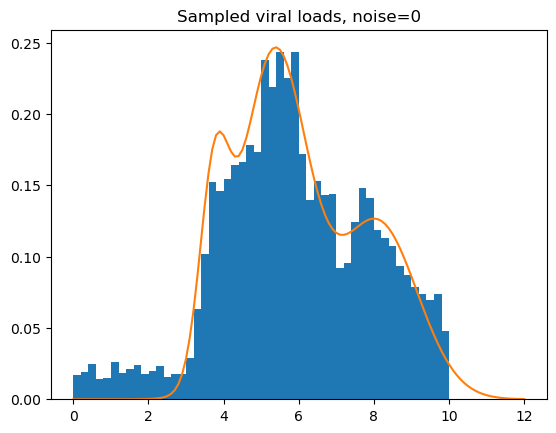

In [7]:
NOISE=0

sampled_vls, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(1,3), (4,6), (11.5, 13.5), (15,17)],
    peak_plateau_height_bounds=(7.5,10),
    tail_height_bounds=(3.5, 6),
    num_samples=7000,
    noise=NOISE
)

sampled_vls_, time_stamps = gen_vl_distribution_with_plateau(
    critical_time_points_bounds=[(1,3), (4,6), (11,11), (11,11)],
    peak_plateau_height_bounds=(5,7),
    tail_height_bounds=(3,3.5),
    num_samples=3000,
    noise=NOISE
)
    
plt.hist(
    sampled_vls + sampled_vls_, bins=50, 
    density=True,
    # weights = np.ones(len(sampled_vls)) / len(sampled_vls)
)
plt.title(f"Sampled viral loads, noise={NOISE}")

plt.plot(x, gmm_pdf)

# GMM
"""
    weights = [0.33, 0.54, 0.13],
    means = [8.09, 5.35, 3.75],
    sigmas = [1.06, 0.89, 0.39]
"""

In [9]:
sampled_vls_all = sampled_vls + sampled_vls_

## Goal: tune the LOD 

so that 
- the sensitivity for single-positive pools is low,
- but the sensitivity for pools with more than one positive is high
- and the sensitivity for individual tests is not low

In [53]:
# put these into one big function for convenience


def tune_LoD(
        sampled_vls_all = sampled_vls_all,
        num_samples = 1000,
        LoD = 174,
        pool_size = 5
):
    print(f"=== Testing LoD = {LoD}, pool_size = {pool_size} ===")
    
    res = {}
    
    # pools with exactly one positive

    positive_vls = np.random.choice(sampled_vls_all, size=num_samples)

    vls = [
        [int(10**positive_vls[i])] + [0]*(pool_size-1)
        for i in range(num_samples)
    ]

    group_testing = OneStageGroupTesting(
        ids=[[0]*5 for _ in range(num_samples)],
        viral_loads=vls,
        pcr_params = {
            "V_sample": 1,
            "c_1": 1/10,
            "xi": 1/2,
            "c_2": 1,
            "LoD": LoD
        }
    )
    test_results, diagnostics = group_testing.run_one_stage_group_testing()
    res["pool_one_pos"] = diagnostics["sensitivity"]
    print(f"average sensitivity for pools with one positive: {diagnostics['sensitivity']}")


    # pools with 2 positives


    positive_vls = np.random.choice(sampled_vls_all, size=2*num_samples)

    vls = [
        [int(10**positive_vls[2*i]), int(10**positive_vls[2*i+1])] + [0]*(pool_size-2)
        for i in range(num_samples)
    ]

    group_testing = OneStageGroupTesting(
        ids=[[0]*5 for _ in range(num_samples)],
        viral_loads=vls,
        pcr_params = {
            "V_sample": 1,
            "c_1": 1/10,
            "xi": 1/2,
            "c_2": 1,
            "LoD": LoD
        }
    )
    test_results, diagnostics = group_testing.run_one_stage_group_testing()
    res["pool_two_pos"] = diagnostics["sensitivity"]
    print(f"average sensitivity for pools with two positives: {diagnostics['sensitivity']}")


    # pools with 3 positives


    positive_vls = np.random.choice(sampled_vls_all, size=3*num_samples)

    vls = [
        [int(10**positive_vls[3*i]), int(10**positive_vls[3*i+1]), int(10**positive_vls[3*i+2])] + [0]*(pool_size-3)
        for i in range(num_samples)
    ]

    group_testing = OneStageGroupTesting(
        ids=[[0]*5 for _ in range(num_samples)],
        viral_loads=vls,
        pcr_params = {
            "V_sample": 1,
            "c_1": 1/10,
            "xi": 1/2,
            "c_2": 1,
            "LoD": LoD
        }
    )
    test_results, diagnostics = group_testing.run_one_stage_group_testing()
    res["pool_three_pos"] = diagnostics["sensitivity"]
    print(f"average sensitivity for pools with three positives: {diagnostics['sensitivity']}")


    # individual 


    ind_test_results = run_one_PCR_test(
        mu=[int(10**positive_vls[i]) for i in range(num_samples)],
        individual=True,
        params = {
            "V_sample": 1,
            "c_1": 1/10,
            "xi": 1/2,
            "c_2": 1,
            "LoD": LoD
        }
    )

    res["ind_test"] = sum(ind_test_results)/num_samples
    print(f"average individual test sensitivity: {sum(ind_test_results)/num_samples}")

    return res

=== Testing LoD = 100, pool_size = 5 ===
average sensitivity for pools with one positive: 0.8384
average sensitivity for pools with two positives: 0.9195
average sensitivity for pools with three positives: 0.9282
average individual test sensitivity: 0.9302
=== Testing LoD = 174, pool_size = 5 ===
average sensitivity for pools with one positive: 0.8036
average sensitivity for pools with two positives: 0.8962
average sensitivity for pools with three positives: 0.9086
average individual test sensitivity: 0.9124
=== Testing LoD = 200, pool_size = 5 ===
average sensitivity for pools with one positive: 0.7894
average sensitivity for pools with two positives: 0.8859
average sensitivity for pools with three positives: 0.9006
average individual test sensitivity: 0.9006
=== Testing LoD = 300, pool_size = 5 ===
average sensitivity for pools with one positive: 0.768
average sensitivity for pools with two positives: 0.8599
average sensitivity for pools with three positives: 0.8765333333333334
avera

Text(0.5, 1.0, 'Sensitivity vs LoD for pool size 5')

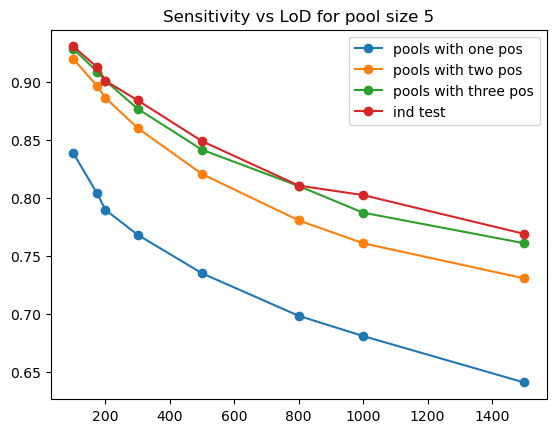

In [60]:
r1 = []
r2 = []
r3 = []
r4 = []
LoD_vals = [100, 174, 200, 300, 500, 800, 1000, 1500]
pool_size = 5
num_samples=5000

for LoD in LoD_vals:
    res = tune_LoD(pool_size=pool_size, num_samples=num_samples, LoD=LoD)
    r1.append(res["pool_one_pos"])
    r2.append(res["pool_two_pos"])
    r3.append(res["pool_three_pos"])
    r4.append(res["ind_test"])

plt.plot(LoD_vals, r1, '-o', label="pools with one pos")
plt.plot(LoD_vals, r2, '-o', label="pools with two pos")
plt.plot(LoD_vals, r3, '-o', label="pools with three pos")
plt.plot(LoD_vals, r4, '-o', label="ind test")
plt.legend()
plt.title(f"Sensitivity vs LoD for pool size {pool_size}")

=== Testing LoD = 100, pool_size = 30 ===
average sensitivity for pools with one positive: 0.7212
average sensitivity for pools with two positives: 0.8806
average sensitivity for pools with three positives: 0.9224666666666667
average individual test sensitivity: 0.9334
=== Testing LoD = 174, pool_size = 30 ===
average sensitivity for pools with one positive: 0.6792
average sensitivity for pools with two positives: 0.846
average sensitivity for pools with three positives: 0.8976666666666666
average individual test sensitivity: 0.9172
=== Testing LoD = 200, pool_size = 30 ===
average sensitivity for pools with one positive: 0.664
average sensitivity for pools with two positives: 0.8387
average sensitivity for pools with three positives: 0.8826666666666667
average individual test sensitivity: 0.9036
=== Testing LoD = 300, pool_size = 30 ===
average sensitivity for pools with one positive: 0.6104
average sensitivity for pools with two positives: 0.7858
average sensitivity for pools with th

Text(0.5, 1.0, 'Sensitivity vs LoD for pool size 30')

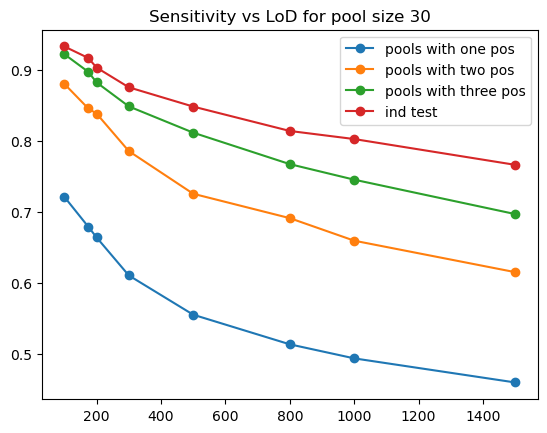

In [59]:
r1 = []
r2 = []
r3 = []
r4 = []
LoD_vals = [100, 174, 200, 300, 500, 800, 1000, 1500]
pool_size = 30
num_samples=5000

for LoD in LoD_vals:
    res = tune_LoD(pool_size=pool_size, num_samples=num_samples, LoD=LoD)
    r1.append(res["pool_one_pos"])
    r2.append(res["pool_two_pos"])
    r3.append(res["pool_three_pos"])
    r4.append(res["ind_test"])

plt.plot(LoD_vals, r1, '-o', label="pools with one pos")
plt.plot(LoD_vals, r2, '-o', label="pools with two pos")
plt.plot(LoD_vals, r3, '-o', label="pools with three pos")
plt.plot(LoD_vals, r4, '-o', label="ind test")
plt.legend()
plt.title(f"Sensitivity vs LoD for pool size {pool_size}")

=== Testing LoD = 100, pool_size = 64 ===
average sensitivity for pools with one positive: 0.6556
average sensitivity for pools with two positives: 0.8393
average sensitivity for pools with three positives: 0.9030666666666667
average individual test sensitivity: 0.9308
=== Testing LoD = 174, pool_size = 64 ===
average sensitivity for pools with one positive: 0.5856
average sensitivity for pools with two positives: 0.7983
average sensitivity for pools with three positives: 0.8862666666666666
average individual test sensitivity: 0.9154
=== Testing LoD = 200, pool_size = 64 ===
average sensitivity for pools with one positive: 0.5782
average sensitivity for pools with two positives: 0.7957
average sensitivity for pools with three positives: 0.8675333333333334
average individual test sensitivity: 0.9078
=== Testing LoD = 300, pool_size = 64 ===
average sensitivity for pools with one positive: 0.5346
average sensitivity for pools with two positives: 0.741
average sensitivity for pools with t

Text(0.5, 1.0, 'Sensitivity vs LoD for pool size 64')

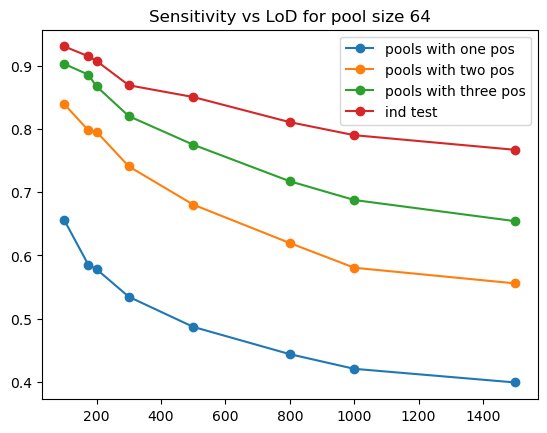

In [61]:
r1 = []
r2 = []
r3 = []
r4 = []
LoD_vals = [100, 174, 200, 300, 500, 800, 1000, 1500]
pool_size = 64
num_samples=5000

for LoD in LoD_vals:
    res = tune_LoD(pool_size=pool_size, num_samples=num_samples, LoD=LoD)
    r1.append(res["pool_one_pos"])
    r2.append(res["pool_two_pos"])
    r3.append(res["pool_three_pos"])
    r4.append(res["ind_test"])

plt.plot(LoD_vals, r1, '-o', label="pools with one pos")
plt.plot(LoD_vals, r2, '-o', label="pools with two pos")
plt.plot(LoD_vals, r3, '-o', label="pools with three pos")
plt.plot(LoD_vals, r4, '-o', label="ind test")
plt.legend()
plt.title(f"Sensitivity vs LoD for pool size {pool_size}")